# Running Everything
This notebook joins the data cleaning and the YOLO/SAM detections to provide the distances of the corners of a box.

In [1]:
import torch
import numpy as np
import cv2
from scipy.spatial import ConvexHull
from scipy.spatial.distance import euclidean
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
from itertools import combinations
import ultralytics
from ultralytics import YOLO, SAM
import pyrealsense2 as rs
import traceback
ultralytics.checks()
print(f"CUDA available {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device={device}")

Ultralytics 8.3.81 🚀 Python-3.9.20 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 2080 Super with Max-Q Design, 7967MiB)
Setup complete ✅ (16 CPUs, 62.5 GB RAM, 411.0/915.3 GB disk)
CUDA available True
device=cuda


In [2]:
boxes_model = YOLO('best.pt')
sam_model = SAM("sam2_t.pt")

In [3]:
def enhance_color_frame(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    l = cv2.equalizeHist(l)
    enhanced_lab = cv2.merge((l, a, b))
    return cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)

def reduce_noise(depths):
    return np.mean(depths, axis=0)


def get_bbox_from_mask(mask: np.ndarray) -> tuple[int, int, int, int]:
    y_indices, x_indices = np.where(mask)
    x_min = int(np.min(x_indices))
    x_max = int(np.max(x_indices))
    y_min = int(np.min(y_indices))
    y_max = int(np.max(y_indices))
    return x_min, y_min, x_max, y_max


def sort_corners(corners:np.ndarray) -> np.ndarray:
    corners = corners.reshape(-1, 2)
    center = np.mean(corners, axis=0)
    angles = np.arctan2(corners[:, 1] - center[1], corners[:, 0] - center[0])
    sorted_indices = np.argsort(angles)
    corners = corners[sorted_indices]
    distances = np.linalg.norm(corners, axis=1)
    top_left_idx = np.argmin(distances)
    corners = np.roll(corners, -top_left_idx, axis=0)
    return corners.reshape(-1, 1, 2)


def select_best_points(corners:np.ndarray) -> np.ndarray:
    corners = sort_corners(corners)

    if corners is None or len(corners) < 6:
        return None
    
    if len(corners) == 6:
        return corners
    
    def are_points_collinear(points):
        for i in range(2, len(points)):
            area = np.linalg.det(np.array([
                [points[0][0], points[0][1], 1],
                [points[1][0], points[1][1], 1],
                [points[i][0], points[i][1], 1]
            ]))
            if abs(area) > 1e-10:
                return False
        return True

    def convex_hull_area(points_subset) -> float:
        if len(points_subset) < 3 or points_subset.shape[1] != 2 or are_points_collinear(points_subset):
            return 0
        
        return ConvexHull(points_subset).volume

    max_area:float = 0
    best_points:Optional[np.ndarray] = None

    for subset in combinations(corners, 6):
        subset:np.ndarray = np.array(subset)
        area:float = convex_hull_area(subset)
        if area > max_area:
            max_area:float = area
            best_points:Optional[np.ndarray] = subset

    if best_points is None or len(best_points) != 6:
        return None

    return best_points


def detect_corners(mask: np.ndarray) -> np.ndarray:
    binary_image = mask.astype(np.uint8) * 255
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    if not contours:
        return None
    
    contour:np.ndarray = max(contours, key=cv2.contourArea)
    factor:float = 0.001
    best_result:np.ndarray = None
    for i in range(100):
        factor:float = factor + 0.001
        epsilon:float = cv2.arcLength(contour, True)*factor
        corners:np.ndarray = np.int32(cv2.approxPolyDP(contour, epsilon, True))
        
        if best_result is None:
            best_result:np.ndarray = corners
        
        elif len(corners) < len(best_result) and len(corners) >= 6:
                best_result:np.ndarray = corners
        
        if len(best_result) == 6:
            break

    return select_best_points(corners)


def read_frame_from_depth_camera(resolution:list[int,int,int]):
    for dev in rs.context().query_devices(): dev.hardware_reset()
    config = rs.config()
    config.disable_all_streams()
    config.enable_stream(rs.stream.depth, resolution[0], resolution[1], rs.format.z16, resolution[2])
    config.enable_stream(rs.stream.color, resolution[0], resolution[1], rs.format.bgr8, resolution[2])

    pipeline = rs.pipeline()
    started = False
    n_frames = 15
    try:
        counter = 0
        depths = []
        images = []
        
        profile = pipeline.start(config)
        started = True
        align = rs.align(rs.stream.color)
        depth_intrinsics = profile.get_stream(rs.stream.depth).as_video_stream_profile().get_intrinsics()

        for _ in range(n_frames):
            pipeline.wait_for_frames()
            
        while True:
            frames = pipeline.wait_for_frames()
            if not frames:
                continue
                
            depth_frame = frames.get_depth_frame()
            color_frame = frames.get_color_frame()
            if not depth_frame or not color_frame:
                continue

            frames = align.process(frames)
            depth_frame = frames.get_depth_frame()
            color_frame = frames.get_color_frame()
            
            counter += 1
            if counter < n_frames:
                depths.append(np.asanyarray(depth_frame.get_data()))
                images.append(np.asanyarray(color_frame.get_data()))
                continue
            
            return enhance_color_frame(images[-1]), reduce_noise(depths), depth_intrinsics
    except:
        traceback.print_exc()
        raise
    finally:
        if started:
            pipeline.stop()


def optimize_mask(mask: np.ndarray, depth_values:np.ndarray, sigma:float) -> np.ndarray:
    object_depth_values = depth_values[mask]

    q1, q3 = np.percentile(object_depth_values, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - sigma * iqr
    upper_bound = q3 + sigma * iqr

    return (mask & (depth_values >= lower_bound) & (depth_values <= upper_bound))


def detect(
    frame:np.ndarray,
    depth_intrinsics:rs.intrinsics,
    depth_values:np.ndarray,
    yolo:YOLO,
    sam:SAM,
    factor:float,
    sigma:float    
):
    result = yolo.predict(source=frame, max_det=1, conf=0.5, verbose=False)[0]
    x1, y1, x2, y2 = result.boxes[0].xyxy[0].tolist()
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

    sam_result = sam(frame, bboxes=[((x1, y1), (x2, y2))], verbose=False)
    masks = sam_result[0].masks.data.cpu().numpy()
    mask = masks[0] if masks is not None and len(masks) > 0 else None
    mask = optimize_mask(mask, depth_values, sigma)
    
    x1, y1, x2, y2 = get_bbox_from_mask(mask)
    
    corners = detect_corners(mask).reshape(-1, 2)
    
    for i, point1 in enumerate(corners.reshape(-1, 2)):
        point2 = corners[i+1] if i < len(corners)-1 else corners[0]
        distance = compute_distance(depth_values, depth_intrinsics, point1, point2, factor)
        print(f"{point1} to {point2} = {distance:.02f}")

    return [x1,y1,x2,y2], mask, corners.reshape(-1, 1, 2)


def compute_distance(
    depth_values:np.ndarray,
    depth_intrinsics:rs.intrinsics,
    p1: tuple[int, int],
    p2: tuple[int, int],
    factor:float
):
    depth1 = depth_values[p1[1], p1[0]]
    depth2 = depth_values[p2[1], p2[0]]
    to_centimeter = 1 / 10
    
    point1_3d = rs.rs2_deproject_pixel_to_point(depth_intrinsics, p1, depth1) 
    point2_3d = rs.rs2_deproject_pixel_to_point(depth_intrinsics, p2, depth2)
    return euclidean(point1_3d, point2_3d) * to_centimeter * factor
    

def draw_detections(
    frame: np.ndarray,
    bbox:tuple[int, int, int, int] = None,
    mask:np.ndarray = None,
    corners:np.ndarray = None,
    is_depth:bool=False,
    color_map=cv2.COLORMAP_RAINBOW
) -> np.ndarray:
    frame = frame.copy()
    thickness:int = 1
    font:int = cv2.FONT_HERSHEY_PLAIN
    scale:float = 0.7
    line_type:int = cv2.LINE_AA
    blue:tuple[int, int, int] = (255, 0, 0)
    green:tuple[int, int, int] = (0, 255, 0)
    red:tuple[int, int, int] = (0, 0, 255)
    white:tuple[int, int, int] = (255, 255, 255)

    if is_depth:
        frame = cv2.applyColorMap(cv2.convertScaleAbs(frame, alpha=0.15), color_map)
    
    if bbox is not None:
        x1, y1, x2, y2 = bbox
        frame = cv2.rectangle(
            frame,
            (x1, y1),
            (x2, y2),
            color=green,
            thickness=thickness,
            lineType=line_type
        )
    if mask is not None:
        mask2 = np.zeros_like(frame)
        mask2[mask == True] = red
        frame = cv2.addWeighted(frame, 1, mask2, 0.1, 0)

        if mask2.dtype != np.uint8:
            mask2 = mask2.astype(np.uint8)
    
        if len(mask2.shape) > 2:
            mask2 = cv2.cvtColor(mask2, cv2.COLOR_BGR2GRAY)
        contours, _ = cv2.findContours(mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        cv2.drawContours(frame, contours, -1, red, thickness*2)

    if corners is not None:
        for corner in corners:
            x1, y1 = corner.ravel()
            cv2.rectangle(frame, (x1+15, y1-10), (x1+120, y1-25), (255,255,255), -1)
            cv2.circle(frame, (x1, y1), 5, (0,255,255), -1)
            cv2.putText(frame, f'{x1}x{y1}', (x1+17, y1-8), font, scale*2, (200,200,200), thickness)
            cv2.putText(frame, f'{x1}x{y1}', (x1+15, y1-10), font, scale*2, (255,0,0), thickness)

    return frame

def imshow(frame1:np.ndarray, frame2:np.ndarray=None, applyColorMap=True, color_map=cv2.COLORMAP_RAINBOW) -> None:
    frame = frame1
    if frame2 is not None:
        if applyColorMap:
            frame2 = cv2.applyColorMap(cv2.convertScaleAbs(frame2, alpha=0.15), color_map)
        frame = np.hstack((frame1, frame2))
        
    plt.figure(figsize=(15, 8))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Capture some frames

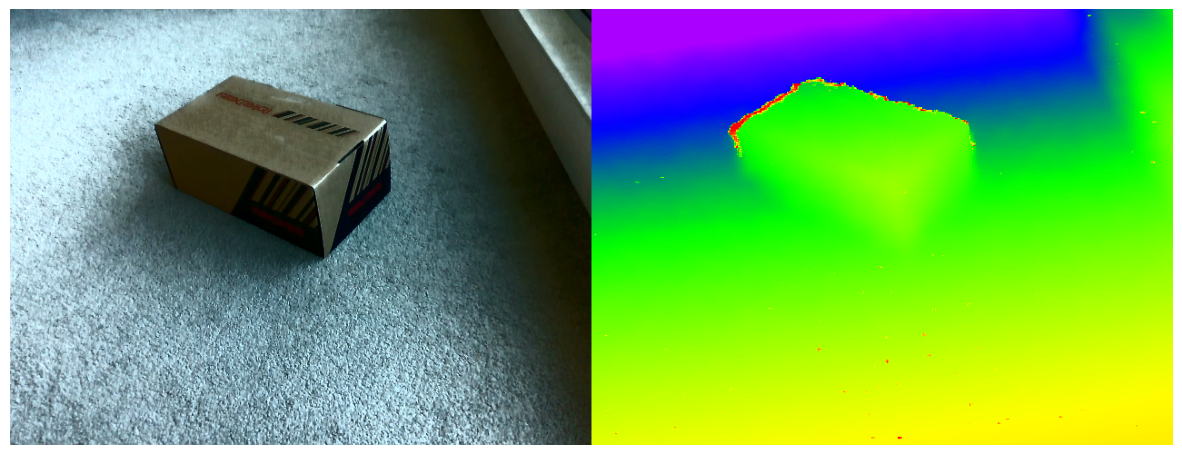

In [4]:
resolution = (640, 480, 30)
color_frame, depth_values, depth_intrinsics = read_frame_from_depth_camera(resolution)
imshow(color_frame, depth_values)

# Render results

[160 133] to [252  75] = 23.31
[252  75] to [412 121] = 37.18
[412 121] to [418 198] = 24.36
[418 198] to [349 271] = 20.49
[349 271] to [185 198] = 38.63
[185 198] to [160 133] = 18.92
Expected: 20, 38, 15, 20, 38, 15


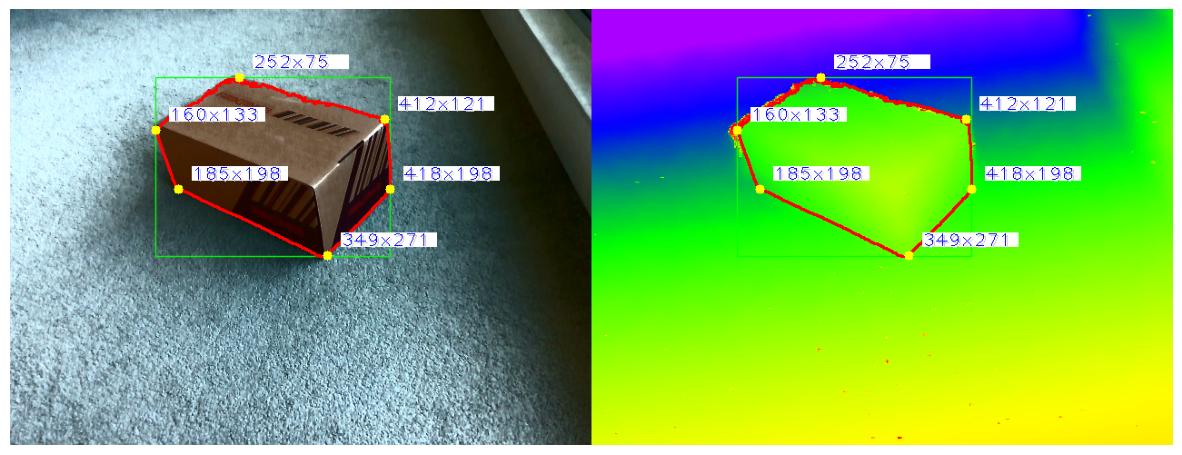

In [5]:
factor = 0.75
sigma=3.5
bbox1, mask1, corners1 = detect(
    color_frame,
    depth_intrinsics,
    depth_values,
    boxes_model,
    sam_model,
    factor,
    sigma
)
print("Expected: 20, 38, 15, 20, 38, 15")
imshow(draw_detections(color_frame, bbox1, mask1, corners1), draw_detections(depth_values, bbox1, mask1, corners1, True), False)